### Гипотеза
Коллеги из маркетинга решили провести исследование эластичности спроса по цене и в рамках него в ноябре запустили А/B/С-тестирование. Суть та же, что в A/B-тестировании, но мы делим пользователей не на 2 группы, а на 3. Задача была в одних и тех же условиях посмотреть, как пользователи реагируют на среднее повышение цены и на сильное повышение цены. Есть гипотеза, что морепродукты — это товар премиум-категории, поэтому даже сильное повышение не снизит нашу конверсию.

### Что у нас есть
- Две базы данных PostgreSQL и Clickhouse
- таблицы purchases, registration и new_events


### Что нужно сделать

1. Определить, есть ли статистически значимое изменение конверсии из регистрации в оплату, а также изменился ли средний чек в группе теста. 
2. По результатам теста написать отчет и сделать рекомендацию руководству, принимая во внимание цель — максимизировать доход.

In [1]:
# Подключение к Postgresql
from c_postgresql_secret import pg_secret
import psycopg2

connection = psycopg2.connect(database = pg_secret['db_name'],
                             user = pg_secret['db_user'],
                             password = pg_secret['db_password'],
                             host = pg_secret['db_host'],
                             port = pg_secret['db_port'])
cursor = connection.cursor()

In [2]:
import pandas as pd

In [3]:
# Создаю запрос для ДФ registration
query_regs = '''SELECT *
                FROM registration'''
cursor.execute(query_regs)
reg_result = cursor.fetchall()
cursor.description


(Column(name='user_id', type_code=23),
 Column(name='registered_at', type_code=1114),
 Column(name='device', type_code=1043),
 Column(name='geo', type_code=1043),
 Column(name='marketing', type_code=1043))

In [4]:
columns_reg = []
for descript in cursor.description:
    columns_reg.append(descript[0])
    
registrations = pd.DataFrame(reg_result, columns = columns_reg)


In [7]:
registrations = registrations.drop_duplicates('user_id') # !исправил удалил дубликаты

In [9]:
#registrations[registrations.user_id == 1412358]

,user_id,registered_at,device,geo,marketing
291763,1412358,2020-11-06 16:35:56,mobile,regions,referral


In [10]:
registrations['user_id'].groupby(registrations['registered_at'].dt.month).nunique()

registered_at
11    293187
Name: user_id, dtype: int64

In [11]:
registrations['marketing'].value_counts()

organic     194841
cpc          40835
social       35011
referral     20498
unknown          2
Name: marketing, dtype: int64

In [12]:
#Создаю запрос для ДФ purchases
query_purch = '''SELECT *
                FROM purchases'''
cursor.execute(query_purch)

purch_result = cursor.fetchall()
cursor.description

(Column(name='user_id', type_code=23), Column(name='order_sum', type_code=701))

In [13]:
columns_purch = []
for descript in cursor.description:
    columns_purch.append(descript[0])
purchases = pd.DataFrame(purch_result, columns = columns_purch)


In [14]:
purchases.head()

,user_id,order_sum
0,1150472,6293.0
1,1380513,9408.0
2,1249084,2812.0
3,1317944,1668.0
4,1338139,4946.0


In [ ]:
# Подключение к Clickhouse

In [15]:
from c_clickhouse_secret import ch_secret
from clickhouse_driver import Client

In [16]:
client = Client(user = ch_secret['db_user'],
               password = ch_secret['db_password'],
               port = ch_secret['db_port'],
               database = ch_secret['db_name'],
               host = ch_secret['db_host'],
               verify = False)

In [17]:
new_events_result, columns = client.execute('SELECT * FROM new_events',
                                           with_column_types = True)
columns

[('user_id', 'UInt64'),
 ('timestamp', 'DateTime'),
 ('test_group', 'String'),
 ('event', 'String')]

In [18]:
new_events_columns = []
for description in columns:
    new_events_columns.append(description[0])
new_events = pd.DataFrame(new_events_result, columns = new_events_columns)

In [19]:
new_events.head()

,user_id,timestamp,test_group,event
0,1256666,2020-11-19 12:14:20,big_increase,registration
1,1225937,2020-11-23 03:37:05,small_increase,registration
2,1265347,2020-11-19 16:15:57,small_increase,registration
3,1332763,2020-11-06 03:10:02,small_increase,registration
4,1317792,2020-11-17 00:45:55,control,registration


In [20]:
new_events['user_id'].groupby(new_events['timestamp'].dt.month).nunique()

timestamp
11    293187
12       139
Name: user_id, dtype: int64

In [21]:
new_events['event'].value_counts()

registration    294078
purchase         33092
Name: event, dtype: int64

Вычисляю окно конверсий
- вычисляю время для принятия решения о покупке
- вычисляю процентили 100, 95, 85
- импортирую визуал 

Для удобства далее я разобью дф new_events на два, в одном будут только регистрации, в другом только покупки. Затем объединю их так чтобы рега и покупка были в одной строке и легче было посчитать разницу во времени.

In [22]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [23]:
new_events_purch = pd.merge(new_events,
                           purchases,
                           how = 'inner',
                           on = 'user_id')

In [24]:
new_events_purch

,user_id,timestamp,test_group,event,order_sum
0,1343452,2020-11-19 15:56:34,small_increase,registration,4023.0
1,1343452,2020-11-20 20:37:40,,purchase,4023.0
2,1287352,2020-11-13 17:30:22,control,registration,3285.0
3,1287352,2020-11-18 15:37:09,,purchase,3285.0
4,1276338,2020-11-24 03:25:42,control,registration,6598.0
...,...,...,...,...,...
66200,1177147,2020-11-11 22:14:44,,purchase,7642.0
66201,1248667,2020-11-04 05:18:36,big_increase,registration,4273.0
66202,1248667,2020-11-07 14:45:38,,purchase,4273.0
66203,1210538,2020-11-09 20:40:37,small_increase,registration,7392.0


In [25]:
new_events_purch['user_id'].groupby(new_events_purch['timestamp'].dt.month).nunique()

timestamp
11    33092
12      139
Name: user_id, dtype: int64

In [29]:
new_events_purch_reg = new_events_purch.loc[new_events_purch['event'] == 'registration']

In [30]:
new_events_purch_reg = new_events_purch_reg.rename(columns = {'timestamp': 'reg_time'}).drop('event', 1)

In [31]:
new_events_purch_reg

,user_id,reg_time,test_group,order_sum
0,1343452,2020-11-19 15:56:34,small_increase,4023.0
2,1287352,2020-11-13 17:30:22,control,3285.0
4,1276338,2020-11-24 03:25:42,control,6598.0
6,1291792,2020-11-23 02:30:08,big_increase,2305.0
8,1397741,2020-11-13 10:29:43,control,1985.0
...,...,...,...,...
66195,1400795,2020-11-09 10:45:59,big_increase,1602.0
66197,1223473,2020-11-12 14:40:09,control,2269.0
66199,1177147,2020-11-11 16:09:26,big_increase,7642.0
66201,1248667,2020-11-04 05:18:36,big_increase,4273.0


In [32]:
new_events_purch_purch = new_events_purch.loc[new_events_purch['event'] == 'purchase']

In [33]:
new_events_purch_purch = new_events_purch_purch.rename(columns = {'timestamp': 'purch_time'})

In [34]:
new_events_purch_purch = new_events_purch_purch.drop('order_sum', 1).drop('event', 1).drop('test_group', 1)

In [35]:
new_events_purch_purch

,user_id,purch_time
1,1343452,2020-11-20 20:37:40
3,1287352,2020-11-18 15:37:09
5,1276338,2020-11-27 04:30:56
7,1291792,2020-11-24 13:28:05
9,1397741,2020-11-17 12:13:37
...,...,...
66196,1400795,2020-11-09 14:44:50
66198,1223473,2020-11-13 08:55:06
66200,1177147,2020-11-11 22:14:44
66202,1248667,2020-11-07 14:45:38


In [36]:
newest_events = pd.merge(new_events_purch_reg,
                        new_events_purch_purch,
                        how = 'inner',
                        on = 'user_id')
newest_events = newest_events[['user_id', 'reg_time', 'purch_time', 'test_group', 'order_sum']]

In [37]:
newest_events

,user_id,reg_time,purch_time,test_group,order_sum
0,1343452,2020-11-19 15:56:34,2020-11-20 20:37:40,small_increase,4023.0
1,1287352,2020-11-13 17:30:22,2020-11-18 15:37:09,control,3285.0
2,1276338,2020-11-24 03:25:42,2020-11-27 04:30:56,control,6598.0
3,1291792,2020-11-23 02:30:08,2020-11-24 13:28:05,big_increase,2305.0
4,1397741,2020-11-13 10:29:43,2020-11-17 12:13:37,control,1985.0
...,...,...,...,...,...
33108,1400795,2020-11-09 10:45:59,2020-11-09 14:44:50,big_increase,1602.0
33109,1223473,2020-11-12 14:40:09,2020-11-13 08:55:06,control,2269.0
33110,1177147,2020-11-11 16:09:26,2020-11-11 22:14:44,big_increase,7642.0
33111,1248667,2020-11-04 05:18:36,2020-11-07 14:45:38,big_increase,4273.0


In [38]:
newest_events['time_delta'] = newest_events['purch_time'] - newest_events['reg_time']

In [39]:
newest_events.head()

,user_id,reg_time,purch_time,test_group,order_sum,time_delta
0,1343452,2020-11-19 15:56:34,2020-11-20 20:37:40,small_increase,4023.0,1 days 04:41:06
1,1287352,2020-11-13 17:30:22,2020-11-18 15:37:09,control,3285.0,4 days 22:06:47
2,1276338,2020-11-24 03:25:42,2020-11-27 04:30:56,control,6598.0,3 days 01:05:14
3,1291792,2020-11-23 02:30:08,2020-11-24 13:28:05,big_increase,2305.0,1 days 10:57:57
4,1397741,2020-11-13 10:29:43,2020-11-17 12:13:37,control,1985.0,4 days 01:43:54


In [40]:
import numpy as np

In [41]:
newest_events['time_delta'] = newest_events['time_delta'] / np.timedelta64(1, 'D') 
#Преобразовал timedelta во float

In [42]:
newest_events.head()

,user_id,reg_time,purch_time,test_group,order_sum,time_delta
0,1343452,2020-11-19 15:56:34,2020-11-20 20:37:40,small_increase,4023.0,1.195208
1,1287352,2020-11-13 17:30:22,2020-11-18 15:37:09,control,3285.0,4.921377
2,1276338,2020-11-24 03:25:42,2020-11-27 04:30:56,control,6598.0,3.045301
3,1291792,2020-11-23 02:30:08,2020-11-24 13:28:05,big_increase,2305.0,1.456910
4,1397741,2020-11-13 10:29:43,2020-11-17 12:13:37,control,1985.0,4.072153


In [43]:
np.percentile(newest_events['time_delta'], 100)

24.12853009259259

In [44]:
np.percentile(newest_events['time_delta'], 95) #Подходящее значение

5.984907407407407

In [45]:
perc_95 = round(np.percentile(newest_events['time_delta'], 95), 1)

C:\Users\Roman\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


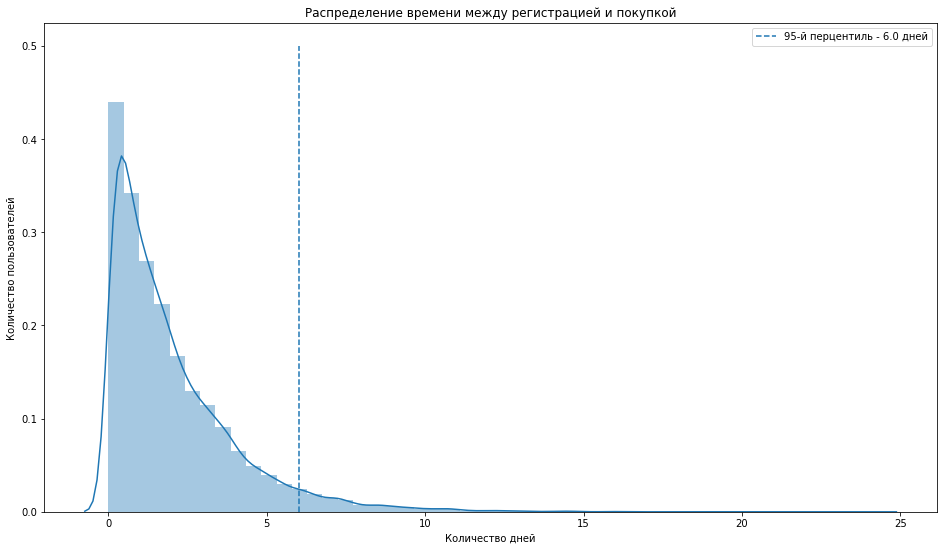

In [46]:
plt.figure(figsize = (16,9))
sns.distplot(newest_events['time_delta'])
plt.vlines(perc_95, ymin = 0, ymax = 0.5, linestyles = 'dashed', label = f'95-й перцентиль - {perc_95} дней')
plt.title('Распределение времени между регистрацией и покупкой')
plt.xlabel('Количество дней')
plt.ylabel('Количество пользователей')
plt.legend()
plt.show()

In [47]:
registrations.groupby('registered_at').max()

,user_id,device,geo,marketing
registered_at,,,,
2020-11-02 13:42:05,1388561,desktop,msk,organic
2020-11-02 13:42:15,1247372,desktop,msk,organic
2020-11-02 13:42:21,1203184,mobile,regions,organic
2020-11-02 13:42:26,1284242,desktop,regions,referral
2020-11-02 13:42:27,1191722,mobile,msk,cpc
...,...,...,...,...
2020-11-24 13:41:18,1317510,tablet,msk,organic
2020-11-24 13:41:19,1274195,mobile,msk,organic
2020-11-24 13:41:44,1308986,desktop,regions,organic


- Очистим данные с учетом окна конверсии. Так как последняя регистрация была сделана 24 ноября, с учетом окна конверсии в 6 дней, нам понадобятся данные по 30 ноября. Соответственно, декабрь не нужен.
- Строим гистограмму для сегментов
- Вычисляем хи квадрат...

Registrations - дф с регистрациями только за ноябрь, то что нам нужно. Соединить registrations c new_events, так как в нем есть данные по сегментам и покупки. Предварительно необходимо из new_events вытащить только данные с покупками за ноябрь.
- отделить от new_events только покупки
- отсортировать за период: ноябрь

In [48]:
from datetime import datetime, timedelta

In [50]:
november_events = new_events.loc[(new_events.timestamp >= datetime(2020,11,1))
                                  & (new_events.timestamp < datetime(2020,12,1))]
november_events = pd.DataFrame(november_events)

In [51]:
november_events

,user_id,timestamp,test_group,event
0,1256666,2020-11-19 12:14:20,big_increase,registration
1,1225937,2020-11-23 03:37:05,small_increase,registration
2,1265347,2020-11-19 16:15:57,small_increase,registration
3,1332763,2020-11-06 03:10:02,small_increase,registration
4,1317792,2020-11-17 00:45:55,control,registration
...,...,...,...,...
327165,1268139,2020-11-19 15:11:26,small_increase,registration
327166,1336773,2020-11-17 13:01:38,small_increase,registration
327167,1400394,2020-11-17 18:05:28,control,registration
327168,1210538,2020-11-09 20:40:37,small_increase,registration


Далее я разбиваю данные по сегментам чтобы увидеть есть ли какие-либо существенные разхождения между группами в каждом сегменте. Для этого построю гистаграмму.

In [52]:
november_events_segments = pd.merge(november_events,
                                   registrations,
                                   how = 'inner',
                                   on = 'user_id')
november_events_segment = november_events_segments.drop('registered_at', 1).dropna()

In [53]:
def plot_segment_distribution(data, segment_columns, test_factor):
    for segment in segment_columns:
        aggregated_data = data.groupby(by = [test_factor, segment])['user_id'].\
        count().reset_index()
        sns.catplot(x = segment,
                   y = 'user_id',
                   data = aggregated_data,
                   hue = test_factor,
                   kind = 'bar',
                   height = 5,
                   aspect = 2)

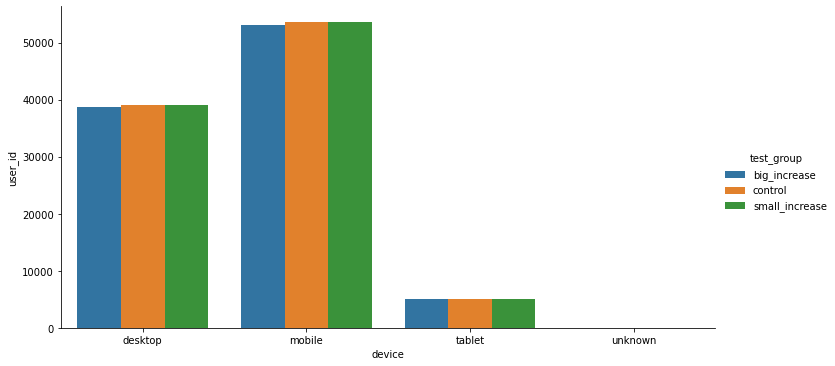

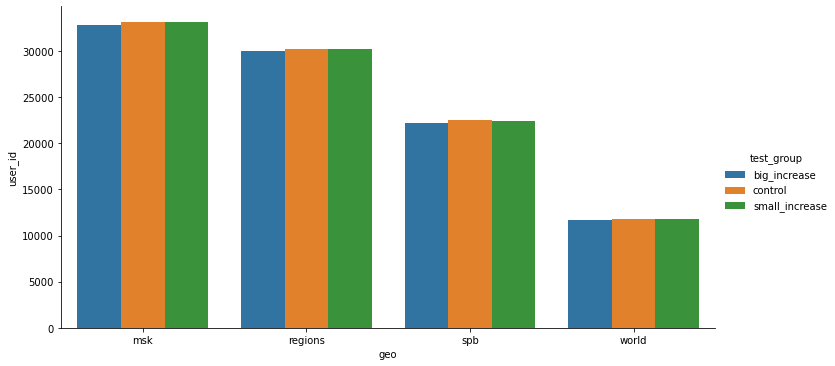

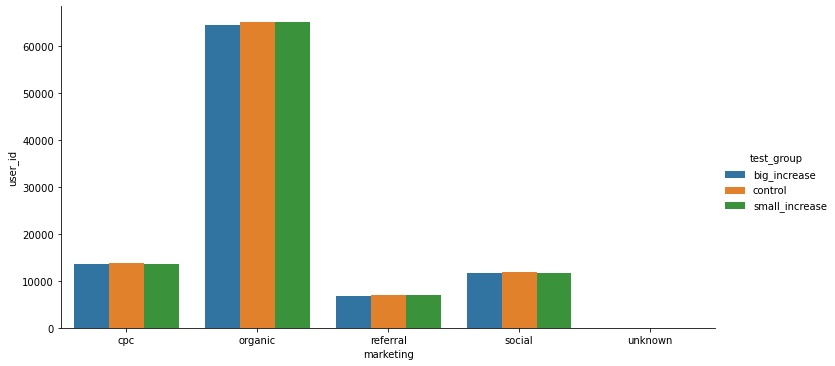

In [54]:
plot_segment_distribution(november_events_segment[november_events_segment['event'] == 'registration'],
                         ['device', 'geo', 'marketing'],
                         'test_group')

Так как в данных по регистрациям нет существенных расхождений, нам не понадобятся какие либо корректировки в исходных данных.

In [91]:
# Теперь приведу таблицу с данными в более удобный вид

,user_id,timestamp,test_group,event,device,geo,marketing
0,1256666,2020-11-19 12:14:20,big_increase,registration,desktop,regions,social
1,1225937,2020-11-23 03:37:05,small_increase,registration,desktop,world,cpc
2,1265347,2020-11-19 16:15:57,small_increase,registration,desktop,regions,cpc
3,1332763,2020-11-06 03:10:02,small_increase,registration,desktop,regions,organic
4,1317792,2020-11-17 00:45:55,control,registration,mobile,regions,organic
...,...,...,...,...,...,...,...
329423,1268139,2020-11-19 15:11:26,small_increase,registration,desktop,world,organic
329424,1336773,2020-11-17 13:01:38,small_increase,registration,desktop,spb,referral
329425,1400394,2020-11-17 18:05:28,control,registration,desktop,msk,organic
329426,1210538,2020-11-09 20:40:37,small_increase,registration,mobile,msk,organic


In [55]:
november_events_segment_reg = november_events_segment.loc[november_events_segment['event'] == 'registration'].\
rename(columns = {'timestamp':'reg_time'})
november_events_segment_regs = november_events_segment_reg.drop('event', 1)
november_events_segment_regs

,user_id,reg_time,test_group,device,geo,marketing
0,1256666,2020-11-19 12:14:20,big_increase,desktop,regions,social
1,1225937,2020-11-23 03:37:05,small_increase,desktop,world,cpc
2,1265347,2020-11-19 16:15:57,small_increase,desktop,regions,cpc
3,1332763,2020-11-06 03:10:02,small_increase,desktop,regions,organic
4,1317792,2020-11-17 00:45:55,control,mobile,regions,organic
...,...,...,...,...,...,...
327025,1283426,2020-11-06 17:49:26,control,desktop,regions,cpc
327026,1268139,2020-11-19 15:11:26,small_increase,desktop,world,organic
327027,1336773,2020-11-17 13:01:38,small_increase,desktop,spb,referral
327028,1400394,2020-11-17 18:05:28,control,desktop,msk,organic


In [56]:
november_events_segment_purch = november_events_segment.loc[november_events_segment['event'] == 'purchase'].\
rename(columns = {'timestamp':'purch_time'})
november_events_segment_purchs = november_events_segment_purch.drop('test_group', 1).drop('event', 1).\
drop('device', 1).drop('geo', 1).drop('marketing', 1)
november_events_segment_purchs

,user_id,purch_time
28,1343452,2020-11-20 20:37:40
31,1287352,2020-11-18 15:37:09
35,1276338,2020-11-27 04:30:56
57,1291792,2020-11-24 13:28:05
64,1397741,2020-11-17 12:13:37
...,...,...
326994,1400795,2020-11-09 14:44:50
326997,1223473,2020-11-13 08:55:06
327006,1177147,2020-11-11 22:14:44
327010,1248667,2020-11-07 14:45:38


In [57]:
november_segments = pd.merge(november_events_segment_regs,
                            november_events_segment_purchs,
                             how = 'left',
                             on = 'user_id')
november_segments = november_segments[['user_id', 'reg_time', 'purch_time', 'test_group', 'device', 'geo', 'marketing']]

In [58]:
november_segments

,user_id,reg_time,purch_time,test_group,device,geo,marketing
0,1256666,2020-11-19 12:14:20,NaT,big_increase,desktop,regions,social
1,1225937,2020-11-23 03:37:05,NaT,small_increase,desktop,world,cpc
2,1265347,2020-11-19 16:15:57,NaT,small_increase,desktop,regions,cpc
3,1332763,2020-11-06 03:10:02,NaT,small_increase,desktop,regions,organic
4,1317792,2020-11-17 00:45:55,NaT,control,mobile,regions,organic
...,...,...,...,...,...,...,...
292073,1283426,2020-11-06 17:49:26,NaT,control,desktop,regions,cpc
292074,1268139,2020-11-19 15:11:26,NaT,small_increase,desktop,world,organic
292075,1336773,2020-11-17 13:01:38,NaT,small_increase,desktop,spb,referral
292076,1400394,2020-11-17 18:05:28,NaT,control,desktop,msk,organic


Теперь проверим таблицу purchases на выбросы и удалим их

(array([2.5469e+04, 5.2120e+03, 1.8160e+03, 5.8300e+02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([  1065. ,   4890.7,   8716.4,  12542.1,  16367.8,  20193.5,
         24019.2,  27844.9,  31670.6,  35496.3,  39322. ,  43147.7,
         46973.4,  50799.1,  54624.8,  58450.5,  62276.2,  66101.9,
         69927.6,  73753.3,  77579. ,  81404.7,  85230.4,  89056.1,
         92881.8,  96707.5, 100533.2, 104358.9

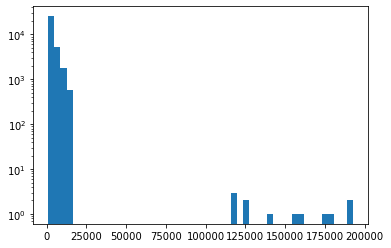

In [59]:
plt.hist(purchases.order_sum,
        bins = 50,
        log = True)

Удалим покупки с чеком выше 25 тысяч рублей, так как это скорее всего оптовые заказы.

In [60]:
purchase_clean = purchases.loc[purchases['order_sum'] < 25000]
purchase_clean.groupby('order_sum').max()

,user_id
order_sum,
1065.0,1405882
1115.0,1409038
1174.0,1411580
1224.0,1408555
1302.0,1411827
...,...
11374.0,1412698
11624.0,1412928
12712.0,1410935


In [61]:
november_data = pd.merge(november_segments,
                         purchase_clean,
                         how = 'left',
                         on = 'user_id')          

In [64]:
november_data = november_data.drop_duplicates('user_id') # !исправил удалил дубликаты
november_data

,user_id,reg_time,purch_time,test_group,device,geo,marketing,order_sum
0,1256666,2020-11-19 12:14:20,NaT,big_increase,desktop,regions,social,NaN
1,1225937,2020-11-23 03:37:05,NaT,small_increase,desktop,world,cpc,NaN
2,1265347,2020-11-19 16:15:57,NaT,small_increase,desktop,regions,cpc,NaN
3,1332763,2020-11-06 03:10:02,NaT,small_increase,desktop,regions,organic,NaN
4,1317792,2020-11-17 00:45:55,NaT,control,mobile,regions,organic,NaN
...,...,...,...,...,...,...,...,...
292073,1283426,2020-11-06 17:49:26,NaT,control,desktop,regions,cpc,NaN
292074,1268139,2020-11-19 15:11:26,NaT,small_increase,desktop,world,organic,NaN
292075,1336773,2020-11-17 13:01:38,NaT,small_increase,desktop,spb,referral,NaN
292076,1400394,2020-11-17 18:05:28,NaT,control,desktop,msk,organic,NaN


In [65]:
#november_data[november_data.user_id == 1412358]

,user_id,reg_time,purch_time,test_group,device,geo,marketing,order_sum
35636,1412358,2020-11-04 12:18:00,2020-11-12 05:08:10,small_increase,mobile,regions,referral,1420.0


In [66]:
# Вычислил время на совершение покупки и преобразовал во float
november_data['time_delta'] = ((november_data['purch_time'] - november_data['reg_time']) / np.timedelta64(1, 'D')).fillna(0)
november_data

,user_id,reg_time,purch_time,test_group,device,geo,marketing,order_sum,time_delta
0,1256666,2020-11-19 12:14:20,NaT,big_increase,desktop,regions,social,NaN,0.000000
1,1225937,2020-11-23 03:37:05,NaT,small_increase,desktop,world,cpc,NaN,0.000000
2,1265347,2020-11-19 16:15:57,NaT,small_increase,desktop,regions,cpc,NaN,0.000000
3,1332763,2020-11-06 03:10:02,NaT,small_increase,desktop,regions,organic,NaN,0.000000
4,1317792,2020-11-17 00:45:55,NaT,control,mobile,regions,organic,NaN,0.000000
...,...,...,...,...,...,...,...,...,...
292073,1283426,2020-11-06 17:49:26,NaT,control,desktop,regions,cpc,NaN,0.000000
292074,1268139,2020-11-19 15:11:26,NaT,small_increase,desktop,world,organic,NaN,0.000000
292075,1336773,2020-11-17 13:01:38,NaT,small_increase,desktop,spb,referral,NaN,0.000000
292076,1400394,2020-11-17 18:05:28,NaT,control,desktop,msk,organic,NaN,0.000000


In [67]:
def map_time(x):
    if 0.0 < x <= 6.0:
        return 1
    else:
        return 0
november_data['within_window'] = november_data['time_delta'].apply(map_time)
november_data
# В столбце within_window я отмечаю 1 пользователей находящихся в окне конверсии

,user_id,reg_time,purch_time,test_group,device,geo,marketing,order_sum,time_delta,within_window
0,1256666,2020-11-19 12:14:20,NaT,big_increase,desktop,regions,social,NaN,0.000000,0
1,1225937,2020-11-23 03:37:05,NaT,small_increase,desktop,world,cpc,NaN,0.000000,0
2,1265347,2020-11-19 16:15:57,NaT,small_increase,desktop,regions,cpc,NaN,0.000000,0
3,1332763,2020-11-06 03:10:02,NaT,small_increase,desktop,regions,organic,NaN,0.000000,0
4,1317792,2020-11-17 00:45:55,NaT,control,mobile,regions,organic,NaN,0.000000,0
...,...,...,...,...,...,...,...,...,...,...
292073,1283426,2020-11-06 17:49:26,NaT,control,desktop,regions,cpc,NaN,0.000000,0
292074,1268139,2020-11-19 15:11:26,NaT,small_increase,desktop,world,organic,NaN,0.000000,0
292075,1336773,2020-11-17 13:01:38,NaT,small_increase,desktop,spb,referral,NaN,0.000000,0
292076,1400394,2020-11-17 18:05:28,NaT,control,desktop,msk,organic,NaN,0.000000,0


In [105]:
november_data['within_window'].value_counts()

0    259747
1     31440
Name: within_window, dtype: int64

In [ ]:
#Вычисляю конверсию и подгружаю statsmodel

In [69]:
metrics = november_data.groupby('test_group').\
agg({'user_id':'count','within_window':'sum', 'order_sum':'mean'})
metrics['conversion'] = round(metrics['within_window']/metrics['user_id']*100, 2)
metrics.reset_index()

,test_group,user_id,within_window,order_sum,conversion
0,big_increase,96417,10299,4211.911537,10.68
1,control,97447,10698,3972.985610,10.98
2,small_increase,97323,10443,3992.492597,10.73


In [70]:
big_small_metrics = metrics.loc[['big_increase', 'small_increase']]

In [71]:
big_control_metrics = metrics.loc[['big_increase', 'control']]

In [72]:
small_control_metrics = metrics.loc[['small_increase', 'control']]

In [73]:
alpha = 0.05

Вычисляем p-value. Данный показатель поможет определить процент вероятности совершения ошибки первого рода.

In [74]:
import statsmodels.stats.proportion as proportion

In [75]:
chi2stat_bsm, pval_bsm, table_bsm = proportion.proportions_chisquare(big_small_metrics['within_window'],
                                                          big_small_metrics['user_id'])
print(pval_bsm, pval_bsm < alpha)

0.729812061498429 False


In [76]:
chi2stat_bcm, pval_bcm, table_bcm = proportion.proportions_chisquare(big_control_metrics['within_window'],
                                                          big_control_metrics['user_id'])
print(pval_bcm, pval_bcm < alpha)

0.035664097786955055 True


In [77]:
chi2stat_scm, pval_scm, table_scm = proportion.proportions_chisquare(small_control_metrics['within_window'],
                                                          small_control_metrics['user_id'])
print(pval_scm, pval_scm < alpha)

0.07850078457991579 False


p-value больше стандартной вероятности ошибки первого рода, для групп сравнения big_increase vs small_increase и small_increase vs control, поэтому мы вынуждены признать что разница в  тестовых группах скорее всего случайна. 
Группа big_increase vs control имеет значение p-value достаточным для того чтобы считать что разница в группе статистически значима.
Применим поправку Бонферрони.

In [78]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [79]:
results = pd.DataFrame({'comparison': ['big_increase vs small_increase', 'big_increase vs control', 'small_increase vs control'],
                        'p-value before': [pval_bsm, pval_bcm, pval_scm],
                        'stat sign before': [False, True, False]})
results

,comparison,p-value before,stat sign before
0,big_increase vs small_increase,0.729812,False
1,big_increase vs control,0.035664,True
2,small_increase vs control,0.078501,False


In [80]:
pvals = results['p-value before']
pvals

0    0.729812
1    0.035664
2    0.078501
Name: p-value before, dtype: float64

In [81]:
results['p-value after correction'] = multipletests(results['p-value before'], method='bonferroni')[1]
results

,comparison,p-value before,stat sign before,p-value after correction
0,big_increase vs small_increase,0.729812,False,1.000000
1,big_increase vs control,0.035664,True,0.106992
2,small_increase vs control,0.078501,False,0.235502


После множественного теста с поправкой Бонферрони, мы видим что статистически значимой разницы для всех трех сравнений нет.


Далее будут применяться обозначения сравнения тестовых групп - их расшифровка:

- bcm - big_increase vs control 
- bsm - big_increase vs small_increase
- scm - small_increase vs control

Буква m означает - metrics

Вычислим мощность тестов. 

In [82]:
import statsmodels.stats.power as smp

In [83]:
chipower = smp.GofChisquarePower()

Создадим функцию effect_size по формуле для определения мощности теста.

In [84]:
def chi2_effect_size(p0, p1):
    return np.sqrt(((p0 - p1)**2 / p0))

In [85]:
bsm_conversion_big = big_small_metrics['conversion'].values[0] / 100
bsm_conversion_small = big_small_metrics['conversion'].values[1] / 100
bsm_nobs = min(big_small_metrics['user_id'])

In [86]:
bcm_conversion_big = big_control_metrics['conversion'].values[0] / 100
bcm_conversion_control = big_control_metrics['conversion'].values[1] / 100
bcm_nobs = min(big_control_metrics['user_id'])

In [87]:
scm_conversion_small = small_control_metrics['conversion'].values[0] / 100
scm_conversion_control = small_control_metrics['conversion'].values[1] / 100
scm_nobs = min(small_control_metrics['user_id'])

In [88]:
bsm_power = chipower.solve_power(effect_size = chi2_effect_size(bsm_conversion_big, bsm_conversion_small),
                                nobs = bsm_nobs,
                                alpha = pval_bsm,
                                power = None)
bsm_power

0.7575774303293445

In [89]:
bcm_power = chipower.solve_power(effect_size = chi2_effect_size(bcm_conversion_big, bcm_conversion_control),
                                nobs = bcm_nobs,
                                alpha = pval_bcm,
                                power = None)
bcm_power

0.7732847513352035

In [90]:
scm_power = chipower.solve_power(effect_size = chi2_effect_size(scm_conversion_small, scm_conversion_control),
                                nobs = scm_nobs,
                                alpha = pval_scm,
                                power = None)
scm_power

0.7328770683197708

In [91]:
power_results = pd.DataFrame({'comparison': ['big_increase vs small_increase', 'big_increase vs control', 'small_increase vs control'],
                        'power': [bsm_power, bcm_power, scm_power]})
power_results

,comparison,power
0,big_increase vs small_increase,0.757577
1,big_increase vs control,0.773285
2,small_increase vs control,0.732877


Здесь мы видим что мощность теста "big_increase vs control" 77% близка к стандартному значению (80%), в то время как в других группах она ниже.

Далее исполульзуем bootstrap для среднего чека.

In [92]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

Создадим массивы с суммами средних чеков для каждой тестовой группы.

In [93]:
ctrl_group = november_data[november_data['test_group'] == 'control']['order_sum'].dropna().values
big_incr_group = november_data[november_data['test_group'] == 'big_increase']['order_sum'].dropna().values
small_incr_group = november_data[november_data['test_group'] == 'small_increase']['order_sum'].dropna().values

In [97]:
bsm_boot_results = bs.bootstrap_ab(test = big_incr_group,
                                  ctrl = small_incr_group,
                                  stat_func = bs_stats.mean,
                                  compare_func = bs_compare.difference,
                                  return_distribution = True)
bsm_boot_results

array([172.97365988, 194.74559765, 238.38642159, ..., 190.60542122,
       252.44781456, 144.26601466])

In [98]:
bcm_boot_results = bs.bootstrap_ab(test = big_incr_group,
                                   ctrl = ctrl_group,
                                   stat_func = bs_stats.mean,
                                   compare_func = bs_compare.difference,
                                   return_distribution = True)
bcm_boot_results

array([274.39394585, 237.9945299 , 302.03325749, ..., 203.24110739,
       241.24183386, 201.60506677])

In [99]:
scm_boot_results = bs.bootstrap_ab(test = small_incr_group,
                                  ctrl = ctrl_group,
                                  stat_func = bs_stats.mean,
                                  compare_func = bs_compare.difference,
                                  return_distribution = True)
scm_boot_results

array([ 63.17623298, -30.18063485, -16.20266572, ...,  14.70813947,
        14.4759928 ,   0.48446462])

Далее перейдем к визуализации результатов и зададим размер доверительного интервала в промежутке
2.5 - 97.5

In [100]:
bsm_borders = np.percentile(bsm_boot_results, [2.5, 97.5])
bcm_borders = np.percentile(bcm_boot_results, [2.5, 97.5])
scm_borders = np.percentile(scm_boot_results, [2.5, 97.5])

C:\Users\Roman\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


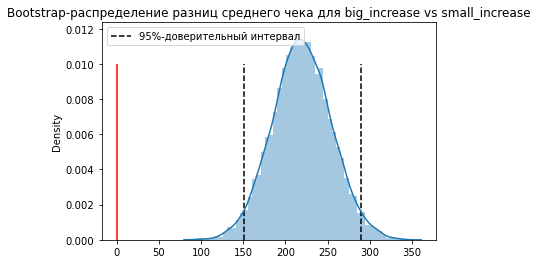

In [101]:
sns.distplot(bsm_boot_results) 
plt.title('Bootstrap-распределение разниц среднего чека для big_increase vs small_increase')
plt.rcParams["figure.figsize"] = (20, 9)
plt.vlines(0, # отрисуем линию на уровне ноля
           ymin = 0, 
           ymax = 0.010, 
           linestyles= '-', 
           colors = 'red')
plt.vlines(bsm_borders, # отрисуем перцентили
           ymin = 0, 
           ymax = 0.010, 
           linestyles= '--', 
           colors = 'k', 
           label = '95%-доверительный интервал')
plt.legend()
plt.show()

Вывод по графику для группы big_increase vs small_increase:
Ноль не входит в доверительный интервал, что говорит о статистически значимых изменениях в среднем чеке в положительную сторону. Чек увеличился в интервале примерно "150р" - "290р". 

C:\Users\Roman\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


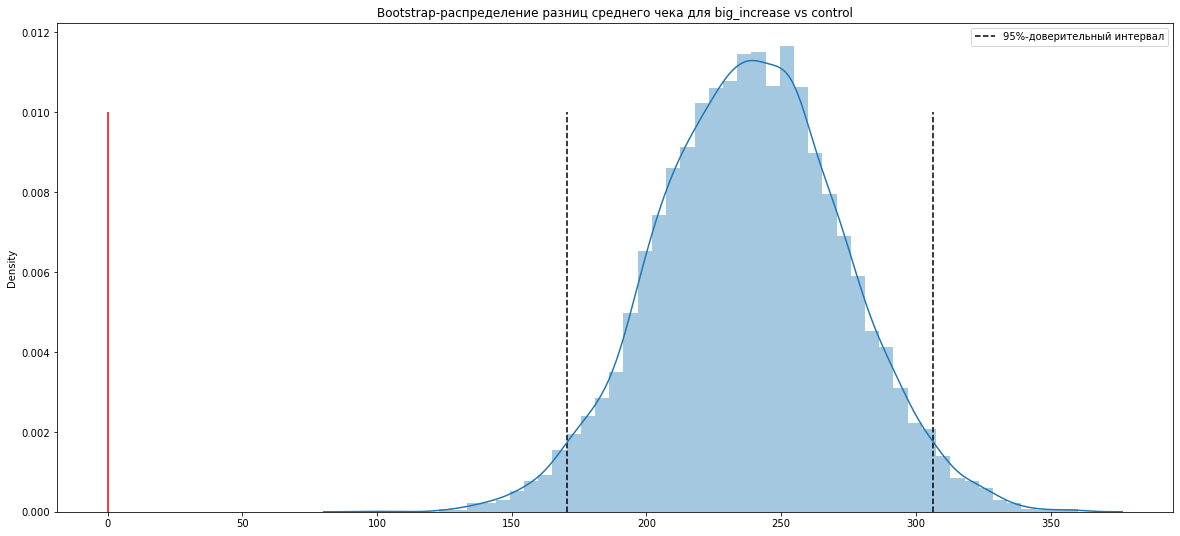

In [102]:
sns.distplot(bcm_boot_results) 
plt.title('Bootstrap-распределение разниц среднего чека для big_increase vs control')
plt.rcParams["figure.figsize"] = (16, 9)
plt.vlines(0, # отрисуем линию на уровне ноля
           ymin = 0, 
           ymax = 0.010, 
           linestyles= '-', 
           colors = 'red')
plt.vlines(bcm_borders, # отрисуем перцентили
           ymin = 0, 
           ymax = 0.010, 
           linestyles= '--', 
           colors = 'k', 
           label = '95%-доверительный интервал')
plt.legend()
plt.show()

Вывод по графику для группы big_increase vs control:
Ноль не входит в доверительный интервал, что говорит также о статистически значимых изменениях в среднем чеке в положительную сторону. Чек увеличился в интервале примерно "170р" - "305р". 

C:\Users\Roman\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


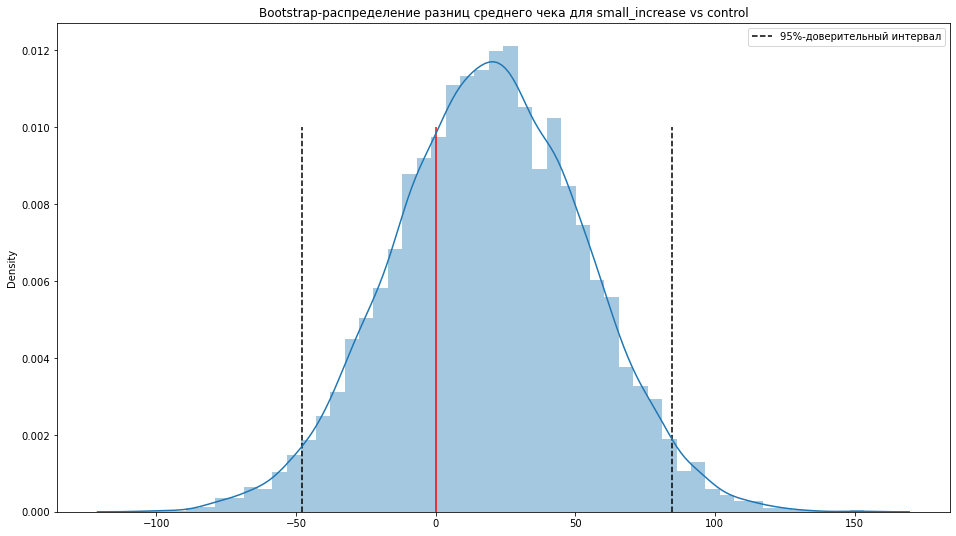

In [103]:
sns.distplot(scm_boot_results) 
plt.title('Bootstrap-распределение разниц среднего чека для small_increase vs control')
plt.rcParams["figure.figsize"] = (16, 9)
plt.vlines(0, # отрисуем линию на уровне ноля
           ymin = 0, 
           ymax = 0.010, 
           linestyles= '-', 
           colors = 'red')
plt.vlines(scm_borders, # отрисуем перцентили
           ymin = 0, 
           ymax = 0.010, 
           linestyles= '--', 
           colors = 'k', 
           label = '95%-доверительный интервал')
plt.legend()
plt.show()

Вывод по графику для группы small_increase vs control:
Значение ноля нахохится практически в центре нашего доверительного интервала, что говорит о негативных изменениях в среднем чеке. Изменения в среднем чеке в интервале примерно: "-50р" - "85р"

Выведем основные показатели, а так же подсчитаем выручку для каждой группы.

In [153]:
total_income = pd.DataFrame(november_data.groupby('test_group')['order_sum'].sum()).reset_index()
#total_income

,test_group,order_sum
0,big_increase,45707664.0
1,control,44727872.0
2,small_increase,43685854.0


In [167]:
control_inc = total_income.loc[[1], ['order_sum']]
ctrl_inc = control_inc.iloc[0]['order_sum']
ctrl_inc

44727872.0

In [168]:
total_income['control_group'] = [ctrl_inc, ctrl_inc, ctrl_inc]

In [173]:
total_income['percentage'] = round(((total_income['order_sum'] - total_income['control_group']) / total_income['control_group']) * 100, 1)

In [104]:
#Подвинул ячейку чтобы таблицы с результатами были рядом
total = pd.merge(results,
                 power_results,
                 how = 'inner',
                 on = 'comparison')
total['check_diff'] = ['150 - 290', '170 - 305', '-50 - 85']
total = total.drop('stat sign before', 1)
total

,comparison,p-value before,p-value after correction,power,check_diff
0,big_increase vs small_increase,0.729812,1.000000,0.757577,150 - 290
1,big_increase vs control,0.035664,0.106992,0.773285,170 - 305
2,small_increase vs control,0.078501,0.235502,0.732877,-50 - 85


In [175]:
total_income.drop('control_group', 1)

,test_group,order_sum,percentage
0,big_increase,45707664.0,2.2
1,control,44727872.0,0.0
2,small_increase,43685854.0,-2.3


Итог:

Тест small_increase vs control
Не смотря на что изменение в конверсии имеет статистически значимую разницу и мощность теста близкую к стандартному значению, изменения для среднего чека показывают негативную динамику. Так как задача бизнеса - увеличение прибыли, данный сценарий нам не подходит.

Тест big_increase vs small_increase
Не смотря на статистически значимую разницу среднего чека и его положительную динамику, разница в конверсии имеет высокую вероятность ошибки первого рода, после поправки Бонферрони она вообще имеет значение 100%, что говорит об отсутствии разницы в данной группе. Также мощность теста имеет самое низкое значение среди всех групп. Поэтому мы отклоняем данную теорию.

Тест big_increase vs control
Изменение в конверсии имеет статистически значимое значение, после поправки Бонферрони составляет самое низкое значение среди остальных групп - 10%. Мощность теста в данной группе самая высокая 75% и наиболее приближена к стандартному показателю в 80%. Также здесь присутствует статистически значимое изменение по среднему чеку и самую высокую по динамике, что в свою очередь помогает бизнесу выполнять основную задачу в увеличении прибыли.



Следует заметить, что высокое повышение цен привело к увеличению общей выручки на 2,2%, в то время как невысокое увеличение привело к ее снижению на 2,3%.